In [ ]:
from pathlib import Path
import pandas as pd
from graphs.calculate_graph_stats import analyze_model_output
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:
dpath = Path('/home/jdabrowski/data/datasets/external/CNV-1-unsharded')
vis_dir = Path('/home/jdabrowski/code/diagnosing/out_dir/vis')
# dpath = Path('/home/jdabrowski/data/datasets/external/POSTERIOR-HEALTHY-1-FR130-NEGATIVES-sharded')
# dpath = Path('/home/jdabrowski/data/datasets/external/CNV-1-newer')
stats_path = dpath/'anom_stats.csv'
if stats_path.exists():
    anom_stats = pd.read_csv(stats_path)
else:
    anom_stats = analyze_model_output(dpath, csv_path=dpath)
    
anom_stats['exam_name_short'] = anom_stats.exam_name.str[:10] + '_' + anom_stats.exam_name.str[-10:-6]
anom_stats['area_um2_int'] =anom_stats['area_um2'].astype(int)

In [11]:
(anom_stats.groupby("class")["area_um2"]
    .agg(["count", "min", "max", "mean", "std"])
    .reset_index())

,class,count,min,max,mean,std


In [10]:
(anom_stats.groupby("exam_name_short")
    .agg(
        anomaly_count=("component_id", "count"),
        # anomaly_size=("area_um2_int", "sum"),
        bscan_count=("bscan_index", lambda x: x.nunique())
    )
    .reset_index()
    .sort_values("anomaly_count", ascending=False)
    # .head(10)
)

,exam_name_short,anomaly_count,bscan_count
3,CNV ANGIO__1106,127,127
2,CNV ANGIO__0834,101,101
1,CNV AND ED_0657,80,80
0,CNV AMD BO_1929,20,20
5,PERIPAPILL_2539,14,14
4,CNV BOTH E_3738,2,2


if you were to take only the bscans with anomalies above the threshold

In [6]:
# threshold = 50_000
threshold = 300_000
big = anom_stats[anom_stats["area_um2"] > threshold]

In [7]:
df=(big.groupby("exam_name_short")
    .agg(
        anomaly_count=("component_id", "count"),
        bscan_count=("bscan_index", lambda x: x.nunique())
    )
    .reset_index()
    .sort_values("anomaly_count", ascending=False)
    # .head(10)
)
totals = df[["anomaly_count", "bscan_count"]].sum()
totals["exam_name_short"] = "TOTAL"
df = pd.concat([df, pd.DataFrame([totals])], ignore_index=True)
df

,exam_name_short,anomaly_count,bscan_count
0,CNV AND ED_0657,1,1
1,TOTAL,1,1


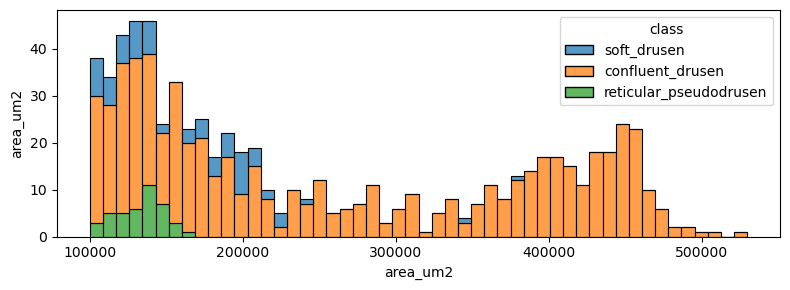

In [5]:

plt.figure(figsize=(8, 3))
sns.histplot(
    data=anom_stats[anom_stats["area_um2"] > 100_000],
    x="area_um2", 
    # hue="exam_name_short",
    hue="class",
    multiple='stack', 
    bins=50
)
plt.ylabel("area_um2")
plt.tight_layout()
plt.show()

In [15]:
from jan.py import *
df = anom_stats[(anom_stats["area_um2"] > 100_000)].sort_values("area_um2").tail(10)
for row in tqdm([exam[1] for exam in list(df.iterrows())]):
    DS(dpath, [row.exam_name]).get(row.bscan_index).plot(
        # borders=False,
        title_suffix=f"\nclass={row['class']} | area_um2={row['area_um2']:.1f}",
        save=vis_dir/'test'
    )

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


In [42]:
from jan.py import *
top_per_class = (
    anom_stats.sort_values("area_um2", ascending=False)
    .groupby("class")
    .head(5)
)
for row in tqdm([aclass[1] for aclass in list(top_per_class.iterrows())]):
    DS(dpath, [row.exam_name]).get(row.bscan_index).plot(
        borders=False,
        title_suffix=f"\nclass={row['class']} area_um2={row['area_um2']:.1f}",
        save=vis_dir/'biggest_per_class'/row['class']/row['exam_name']
    )

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


In [37]:
from jan.py import *
top_per_exam = (
    anom_stats.sort_values("area_um2", ascending=False)
    .groupby("exam_name")
    .head(5)
)
for row in tqdm([exam[1] for exam in list(top_per_exam.iterrows())]):
    DS(dpath, [row.exam_name]).get(row.bscan_index).plot(
        borders=False,
        title_suffix=f"\nclass={row['class']} area_um2={row['area_um2']:.1f}",
        save=vis_dir/'biggest_per_exam'/row['exam_name']
    )

100%|██████████| 65/65 [01:46<00:00,  1.63s/it]


In [45]:
from jan.py import *
df = anom_stats[anom_stats["area_um2"] > 100_000].sort_values("area_um2").head(20)
for row in tqdm([exam[1] for exam in list(df.iterrows())]):
    DS(dpath, [row.exam_name]).get(row.bscan_index).plot(
        borders=False,
        title_suffix=f"\nclass={row['class']} | area_um2={row['area_um2']:.1f}",
        save=vis_dir/'threshold_100_000_smallest'/row['exam_name']
    )

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


In [46]:
from jan.py import *
df = anom_stats[(anom_stats["area_um2"] > 100_000) & (anom_stats['class'] == 'confluent_drusen')].sort_values("area_um2").head(20)
for row in tqdm([exam[1] for exam in list(df.iterrows())]):
    DS(dpath, [row.exam_name]).get(row.bscan_index).plot(
        borders=False,
        title_suffix=f"\nclass={row['class']} | area_um2={row['area_um2']:.1f}",
        save=vis_dir/'threshold_100_000_smallest_confluent_only'/row['exam_name']
    )

100%|██████████| 20/20 [00:19<00:00,  1.05it/s]
